# Week 13-1 - RANDOM FORESTS AND BOOSTING

This lecture is comprised of 4 parts:

- 1. CART Baseline

- 2. Random Forests (basic model and cross-validation)

- 3. Gradient Boosted Trees (basic model and cross-validation)

- 4. Final Comparison

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [42]:
ctr = pd.read_csv("CTR.csv")
ctr.info()
ctr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6057 entries, 0 to 6056
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CTR            6057 non-null   float64
 1   titleWords     6057 non-null   int64  
 2   adWords        6057 non-null   int64  
 3   depth          6057 non-null   int64  
 4   position       6057 non-null   int64  
 5   advCTR         6057 non-null   float64
 6   advCTRInPos    6057 non-null   float64
 7   queryCTR       6057 non-null   float64
 8   queryCTRInPos  6057 non-null   float64
 9   gender         6057 non-null   object 
 10  age            6057 non-null   object 
dtypes: float64(5), int64(4), object(2)
memory usage: 520.7+ KB


,CTR,titleWords,adWords,depth,position,advCTR,advCTRInPos,queryCTR,queryCTRInPos,gender,age
0,0.0000,8,17,1,1,0.0136,0.0153,0.0000,0.0000,male,0-12
1,0.0000,9,19,3,3,0.0199,0.0088,0.0394,0.0125,male,25-30
2,0.0675,6,30,2,1,0.0825,0.1002,0.0200,0.0256,female,13-18
3,0.0000,5,19,3,2,0.0116,0.0090,0.0042,0.0017,female,25-30
4,0.0000,10,22,1,1,0.0186,0.0284,0.0294,0.0431,female,0-12


In [43]:
def OSR2(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

## 1. CART BASELINE

### Decision Tree Regressor with CV

We will use a standard decision tree to establish a reference against which to evaluate the ensemble models

#### 1.0 Train test split

In [44]:
from sklearn.model_selection import train_test_split

y = ctr['CTR']
X = pd.get_dummies(ctr.drop(['CTR'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)
X_train.shape, X_test.shape

((4239, 18), (1818, 18))

#### 1.1 Define the grid values and perform the Grid Search Cross-Validation

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold

grid_values = {'ccp_alpha': np.linspace(0, 0.001, 51)}

dtr = DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=20, random_state=88)
### Note that the line below is important. It ensures that the training data is split into
### five folds randomly. Recall what we've seen in the discussion slides that by default,
### GridSearchCV will split the training data without shuffling. 
cv = KFold(n_splits=5,random_state=1,shuffle=True) 
### by setting random_state as a fixed number, we ensure that each time the GridSearchCV splits data, we get the 
### same split.
dtr_cv = GridSearchCV(dtr, param_grid=grid_values, scoring='r2', cv=cv, verbose=0)
dtr_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=DecisionTreeRegressor(min_samples_leaf=5,
                                             min_samples_split=20,
                                             random_state=88),
             param_grid={'ccp_alpha': array([0.0e+00, 2.0e-05, 4.0e-05, 6.0e-05, 8.0e-05, 1.0e-04, 1.2e-04,
       1.4e-04, 1.6e-04, 1.8e-04, 2.0e-04, 2.2e-04, 2.4e-04, 2.6e-04,
       2.8e-04, 3.0e-04, 3.2e-04, 3.4e-04, 3.6e-04, 3.8e-04, 4.0e-04,
       4.2e-04, 4.4e-04, 4.6e-04, 4.8e-04, 5.0e-04, 5.2e-04, 5.4e-04,
       5.6e-04, 5.8e-04, 6.0e-04, 6.2e-04, 6.4e-04, 6.6e-04, 6.8e-04,
       7.0e-04, 7.2e-04, 7.4e-04, 7.6e-04, 7.8e-04, 8.0e-04, 8.2e-04,
       8.4e-04, 8.6e-04, 8.8e-04, 9.0e-04, 9.2e-04, 9.4e-04, 9.6e-04,
       9.8e-04, 1.0e-03])},
             scoring='r2')

#### 1.2 Select the best hyperparameter

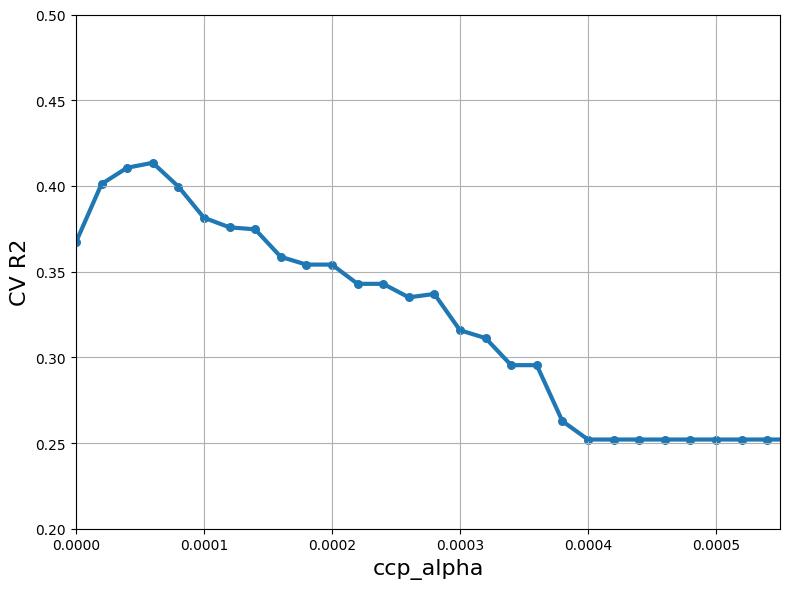

In [7]:
ccp_alpha = dtr_cv.cv_results_['param_ccp_alpha'].data
R2_scores = dtr_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('ccp_alpha', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(ccp_alpha, R2_scores, s=30)
plt.plot(ccp_alpha, R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.xlim([0, 0.00055])
plt.ylim([0.2, 0.5])

plt.tight_layout()
plt.show()

In [8]:
print('Best ccp_alpha', dtr_cv.best_params_)

Best ccp_alpha {'ccp_alpha': 6.000000000000001e-05}


#### 1.3 Evaluate the model performance (trained on the entire training set)

In [9]:
# Model Evaluation
print('Cross-validated R2:', round(dtr_cv.best_score_, 5))
print('OSR2:', round(OSR2(dtr_cv, X_test, y_test, y_train), 5))

Cross-validated R2: 0.41349
OSR2: 0.4819


## 2. RANDOM FORESTS

### 2.1 Random Forest Regressor

In [10]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=5, min_samples_leaf=5, 
                           n_estimators = 500, random_state=88, verbose=1)
# Note: you can change the verbose parameter to control how much training progress is printed.
rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    2.0s


RandomForestRegressor(max_features=5, min_samples_leaf=5, n_estimators=500,
                      random_state=88, verbose=1)

In [11]:
rf.verbose = False

print('OSR2:', round(OSR2(rf, X_test, y_test, y_train), 5))

OSR2: 0.56467


#### Feature Importance

In [12]:
pd.DataFrame({'Feature' : X_train.columns, 
              'Importance score': 100*rf.feature_importances_}).round(1)

,Feature,Importance score
0,titleWords,3.7
1,adWords,3.4
2,depth,2.3
3,position,2.2
4,advCTR,23.6
5,advCTRInPos,32.6
6,queryCTR,10.0
7,queryCTRInPos,17.9
8,gender_female,0.8
9,gender_male,0.5


### 2.2 Random Forest Regressor with CV

#### 2.2.1 Define the grid values and perform the Grid Search Cross-Validation

In [13]:
import time

grid_values = {'max_features': np.linspace(1,25,25, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [40],
               'random_state': [88]} 

tic = time.time()

rf2 = RandomForestRegressor() 
# Note: here we set verbose=2 to keep track of the progress (the running time) of the cross validation. 
cv = KFold(n_splits=5,random_state=2333,shuffle=True) 
rf_cv = GridSearchCV(rf2, param_grid=grid_values, scoring='r2', cv=cv,verbose=1)
rf_cv.fit(X_train, y_train)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
time: 37.07 s


####  2.2.2 Select the best hyperparameter

(0.4, 0.55)

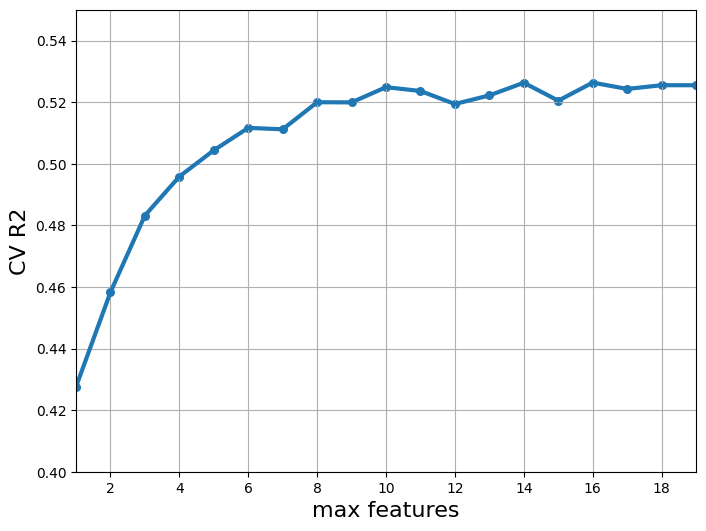

In [14]:
max_features = rf_cv.cv_results_['param_max_features'].data
R2_scores = rf_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(max_features, R2_scores, s=30)
plt.plot(max_features, R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.xlim([1, 19])
plt.ylim([0.4, 0.55])

In [15]:
print(rf_cv.best_params_)

{'max_features': 16, 'min_samples_leaf': 5, 'n_estimators': 40, 'random_state': 88}


#### 2.2.3 Evaluate the model performance (trained on the entire training set)

In [16]:
print('Cross-validated R2:', round(rf_cv.best_score_, 5))
print('OSR2:', round(OSR2(rf_cv, X_test, y_test, y_train), 5))

Cross-validated R2: 0.52633
OSR2: 0.55854


#### 2.2.4 Feature Importance

In [17]:
pd.DataFrame({'Feature' : X_train.columns,  
              'Importance score': 100*rf_cv.best_estimator_.feature_importances_}).round(1)


,Feature,Importance score
0,titleWords,3.6
1,adWords,3.1
2,depth,1.8
3,position,0.3
4,advCTR,16.4
5,advCTRInPos,43.7
6,queryCTR,6.8
7,queryCTRInPos,21.6
8,gender_female,0.5
9,gender_male,0.5


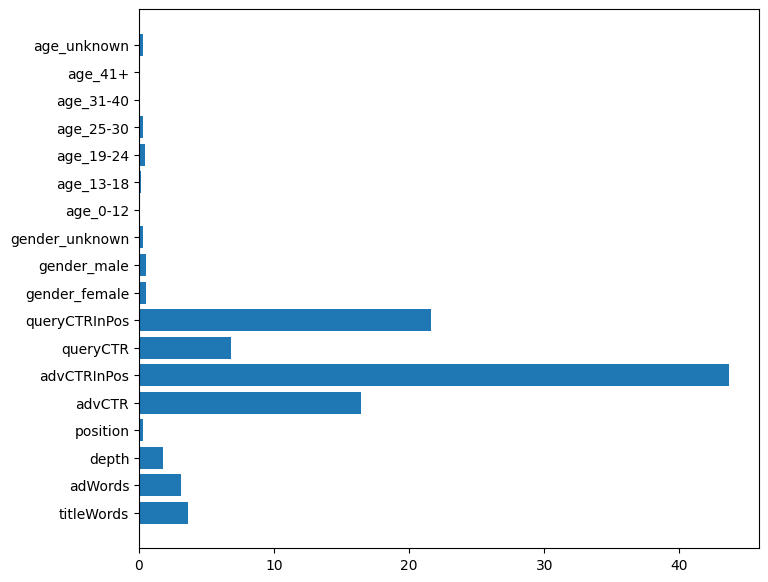

In [18]:
plt.figure(figsize=(8,7))
plt.barh(X_train.columns, 100*rf_cv.best_estimator_.feature_importances_)
plt.show()

## 3. GRADIENT BOOSTED TREES

### 3.1 Gradient Boosting Regressor

Controlling tree size using `max_leaf_nodes` vs. `max_depth`: https://scikit-learn.org/stable/modules/ensemble.html#controlling-the-tree-size

We choose use `max_leaf_nodes` as our primary parameter to control the size of the tree: we set `max_depth` to a large value so that it does not interfere with the construction of the trees. 

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=2000, learning_rate= 0.001, max_leaf_nodes=3,
                                max_depth=10, min_samples_leaf=10, random_state=88, verbose=2) 
gbr.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.0060            2.21m
         2           0.0060            1.21m
         3           0.0060           51.93s
         4           0.0060           41.42s
         5           0.0060           35.11s
         6           0.0060           31.00s
         7           0.0060           27.97s
         8           0.0060           25.71s
         9           0.0060           23.96s
        10           0.0060           22.57s
        11           0.0060           21.45s
        12           0.0060           20.47s
        13           0.0060           19.65s
        14           0.0060           19.02s
        15           0.0060           18.42s
        16           0.0059           17.87s
        17           0.0059           17.41s
        18           0.0059           16.98s
        19           0.0059           16.64s
        20           0.0059           16.34s
        21           0.0059           16.04s
        2

GradientBoostingRegressor(learning_rate=0.001, max_depth=10, max_leaf_nodes=3,
                          min_samples_leaf=10, n_estimators=2000,
                          random_state=88, verbose=2)

In [20]:
print('OSR2:', round(OSR2(gbr, X_test, y_test, y_train), 5))

OSR2: 0.4388


Note that the OSR2 of the above gbr model is not very good. It is because the model is quite sensitive to hypterparameters. We will learn how to find the best parameters using cross-validation and see the improvement one could get from choosing the best hyperparameters.

### 3.2 Gradient Boosting Regressor with CV

Note that if you use the `GridSearchCV` function directly with the gbr as the classifier, the run-time is super long (e.g., more than 30 hours). The reason is that the naive implement of `GridSearchCV` does not take into account the special additive nature of the Boosting models. 

For example, if you need to decide what is the best number of trees to include in your model and you would like to try values from 1 to 10000. The naive implementation of `GridSearchCV` would train 10000 different gbr models. However, a much more efficient way is to train a model with 10000 trees, and only subset a subset of them in your model when needed. This trick allows us to reduce the training time of gbr_cv to less than 2 hours. 

If you use the `caret` package in `R`, they have implemented this efficient algorithm, but there is not a good counterpart in `Python` `sklearn`. 

However, we change these values to a small subset to reduce the run-time.

#### 1.1 Split the training data into 5 folds for cross validation

In [21]:
grid_values = {'n_estimators': np.arange(3000, 7000, 20)}

gbr = GradientBoostingRegressor(min_samples_leaf=5, n_estimators=120, min_samples_split=20, random_state=88)

cv = KFold(n_splits=5,random_state=1,shuffle=True) 

gbr_cv = GridSearchCV(gbr, param_grid=grid_values, scoring='r2', cv=cv, verbose=1)
gbr_cv.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/Users/ivynangalia/Library/Python/3.12/lib/python/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=GradientBoostingRegressor(min_samples_leaf=5,
                                                 min_samples_split=20,
                                                 n_estimators=120,
                                                 random_state=88),
             param_grid={'n_estimators': array([3000, 3020, 3040, 3060, 3080, 3100, 3120, 3140, 3160, 3180, 3200,
       3220, 3240, 3260, 3280, 3300, 3320, 3340, 3360, 3380, 3400, 3420,
       3440, 3460, 3480, 3500, 3520, 3540, 3560...
       5640, 5660, 5680, 5700, 5720, 5740, 5760, 5780, 5800, 5820, 5840,
       5860, 5880, 5900, 5920, 5940, 5960, 5980, 6000, 6020, 6040, 6060,
       6080, 6100, 6120, 6140, 6160, 6180, 6200, 6220, 6240, 6260, 6280,
       6300, 6320, 6340, 6360, 6380, 6400, 6420, 6440, 6460, 6480, 6500,
       6520, 6540, 6560, 6580, 6600, 6620, 6640, 6660, 6680, 6700, 6720,
       6740, 6760, 6780, 6800, 6820, 6840, 6860, 6880, 6900, 6920, 6940,
       6960, 6980])},
             scoring='r2', verbose=1)

#### 1.6 Train the model with the best hyperparameters on the full training data.

In [58]:
gbr_cv = GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.005, max_depth = 20,
                                max_leaf_nodes=7, min_samples_leaf=10,random_state=99,verbose=1)
gbr_cv.fit(X_train,y_train)

      Iter       Train Loss   Remaining Time 
         1           0.0060            1.31m
         2           0.0060           54.35s
         3           0.0059           45.81s
         4           0.0059           41.34s
         5           0.0059           38.82s
         6           0.0059           36.53s
         7           0.0058           34.81s
         8           0.0058           33.55s
         9           0.0058           32.57s
        10           0.0058           31.54s
        20           0.0055           26.63s
        30           0.0053           24.98s
        40           0.0051           23.99s
        50           0.0050           24.07s
        60           0.0048           23.90s
        70           0.0047           23.70s
        80           0.0045           23.77s
        90           0.0044           23.73s
       100           0.0043           23.67s
       200           0.0035           24.50s
       300           0.0031           24.04s
       40

GradientBoostingRegressor(learning_rate=0.005, max_depth=20, max_leaf_nodes=7,
                          min_samples_leaf=10, n_estimators=5000,
                          random_state=99, verbose=1)

#### 1.7 Evaluate the full model

In [54]:
print('OSR2:', round(OSR2(gbr_cv, X_test, y_test, y_train), 5))

OSR2: 0.53653


In [55]:
pd.DataFrame({'Feature' : X_train.columns, 
              'Importance score': 100*gbr_cv.feature_importances_}).round(1)

,Feature,Importance score
0,titleWords,1.7
1,adWords,2.0
2,depth,2.4
3,position,0.4
4,advCTR,13.2
5,advCTRInPos,52.6
6,queryCTR,4.8
7,queryCTRInPos,21.4
8,gender_female,0.5
9,gender_male,0.2


## 4. Final Comparison

### 4.1 Linear Regression Baseline

In [56]:
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

lr = LinearRegression().fit(X_train, y_train)

### 4.2 Comparison Table

In [62]:
comparison_data = {'Linear Regression': ['{:.3f}'.format(OSR2(lr, X_test, y_test, y_train)),
                                         '{:.4f}'.format(metrics.mean_squared_error(y_test, lr.predict(X_test))),
                                         '{:.3f}'.format(metrics.mean_absolute_error(y_test, lr.predict(X_test)))],
                   'Decision Tree Regressor': ['{:.3f}'.format(OSR2(dtr_cv, X_test, y_test, y_train)),
                                               '{:.4f}'.format(metrics.mean_squared_error(y_test, dtr_cv.predict(X_test))),
                                               '{:.3f}'.format(metrics.mean_absolute_error(y_test, dtr_cv.predict(X_test)))],
                   'Random Forest': ['{:.3f}'.format(OSR2(rf_cv, X_test, y_test, y_train)),
                                     '{:.4f}'.format(metrics.mean_squared_error(y_test, rf_cv.predict(X_test))),
                                     '{:.3f}'.format(metrics.mean_absolute_error(y_test, rf_cv.predict(X_test)))], 
                   'Gradient Boosted Trees': ['{:.3f}'.format(OSR2(gbr_cv, X_test, y_test, y_train)),
                                              '{:.4f}'.format(metrics.mean_squared_error(y_test, gbr_cv.predict(X_test))),
                                              '{:.3f}'.format(metrics.mean_absolute_error(y_test, gbr_cv.predict(X_test)))]}

comparison_table = pd.DataFrame(data=comparison_data, index=['OSR2', 'Out-of-sample MSE', 'Out-of-sample MAE'])
comparison_table.style.set_properties(**{'font-size': '12pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])

,Linear Regression,Decision Tree Regressor,Random Forest,Gradient Boosted Trees
OSR2,0.488,0.482,0.559,0.537
Out-of-sample MSE,0.0028,0.0028,0.0024,0.0025
Out-of-sample MAE,0.032,0.033,0.029,0.030


Let's look at MAE restricted to CTR above and below 10%

## In-class activity: Check if the prediction accuracy are different for low CTR and high CTR items. Use CTR <=0.1 or CTR > 0.1 as a threshold.

 - Specifically, split the testing set to two subsets by CTR values. Evaluate the performance on each subset.



In [59]:
X_test_low = X_test[y_test <= 0.1]
y_test_low = y_test[y_test <= 0.1]

In [63]:
comparison_data = {'Linear Regression': ['{:.3f}'.format(OSR2(lr, X_test_low, y_test_low, y_train)),
                                         '{:.4f}'.format(metrics.mean_squared_error(y_test_low, lr.predict(X_test_low))),
                                         '{:.3f}'.format(metrics.mean_absolute_error(y_test_low, lr.predict(X_test_low)))],
                   'Decision Tree Regressor': ['{:.3f}'.format(OSR2(dtr_cv, X_test_low, y_test_low, y_train)),
                                               '{:.4f}'.format(metrics.mean_squared_error(y_test_low, dtr_cv.predict(X_test_low))),
                                               '{:.3f}'.format(metrics.mean_absolute_error(y_test_low, dtr_cv.predict(X_test_low)))],
                   'Random Forest': ['{:.3f}'.format(OSR2(rf_cv, X_test_low, y_test_low, y_train)),
                                     '{:.4f}'.format(metrics.mean_squared_error(y_test_low, rf_cv.predict(X_test_low))),
                                     '{:.3f}'.format(metrics.mean_absolute_error(y_test_low, rf_cv.predict(X_test_low)))], 
                   'Gradient Boosted Trees': ['{:.3f}'.format(OSR2(gbr_cv, X_test_low, y_test_low, y_train)),
                                              '{:.4f}'.format(metrics.mean_squared_error(y_test_low, gbr_cv.predict(X_test_low))),
                                              '{:.3f}'.format(metrics.mean_absolute_error(y_test_low, gbr_cv.predict(X_test_low)))]}

comparison_table = pd.DataFrame(data=comparison_data, index=['OSR2', 'Out-of-sample MSE', 'Out-of-sample MAE'])
comparison_table.style.set_properties(**{'font-size': '12pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])

,Linear Regression,Decision Tree Regressor,Random Forest,Gradient Boosted Trees
OSR2,0.060,0.126,0.245,0.219
Out-of-sample MSE,0.0013,0.0012,0.0010,0.0011
Out-of-sample MAE,0.024,0.024,0.021,0.021


In [39]:
X_test_high = X_test[y_test >= 0.1]
y_test_high = y_test[y_test >= 0.1]

In [64]:
comparison_data = {'Linear Regression': ['{:.3f}'.format(OSR2(lr, X_test_high, y_test_high, y_train)),
                                         '{:.4f}'.format(metrics.mean_squared_error(y_test_high, lr.predict(X_test_high))),
                                         '{:.3f}'.format(metrics.mean_absolute_error(y_test_high, lr.predict(X_test_high)))],
                   'Decision Tree Regressor': ['{:.3f}'.format(OSR2(dtr_cv, X_test_high, y_test_high, y_train)),
                                               '{:.4f}'.format(metrics.mean_squared_error(y_test_high, dtr_cv.predict(X_test_high))),
                                               '{:.3f}'.format(metrics.mean_absolute_error(y_test_high, dtr_cv.predict(X_test_high)))],
                   'Random Forest': ['{:.3f}'.format(OSR2(rf_cv, X_test_high, y_test_high, y_train)),
                                     '{:.4f}'.format(metrics.mean_squared_error(y_test_high, rf_cv.predict(X_test_high))),
                                     '{:.3f}'.format(metrics.mean_absolute_error(y_test_high, rf_cv.predict(X_test_high)))], 
                   'Gradient Boosted Trees': ['{:.3f}'.format(OSR2(gbr_cv, X_test_high, y_test_high, y_train)),
                                              '{:.4f}'.format(metrics.mean_squared_error(y_test_high, gbr_cv.predict(X_test_high))),
                                              '{:.3f}'.format(metrics.mean_absolute_error(y_test_high, gbr_cv.predict(X_test_high)))]}

comparison_table = pd.DataFrame(data=comparison_data, index=['OSR2', 'Out-of-sample MSE', 'Out-of-sample MAE'])
comparison_table.style.set_properties(**{'font-size': '12pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])

,Linear Regression,Decision Tree Regressor,Random Forest,Gradient Boosted Trees
OSR2,0.601,0.575,0.642,0.621
Out-of-sample MSE,0.0113,0.0120,0.0101,0.0107
Out-of-sample MAE,0.080,0.084,0.076,0.079
